In [1]:
import numpy as np
import pandas as pd
import os
import pathlib
from tqdm import tqdm #Progress bar

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input,Flatten,Dense
from tensorflow.keras.models import Model

In [2]:
!nvidia-smi

Sat Jan 14 06:31:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#file paths
base_url = "/kaggle/input/plant-pathology-2020-fgvc7"
image_dir = f"{base_url}/images"
train = f"{base_url}/train.csv"
test = f"{base_url}/test.csv"

### Analyse Data

In [4]:
test_data = pd.read_csv(test) #Test Data
train_data = pd.read_csv(train) #Train Data

train_data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


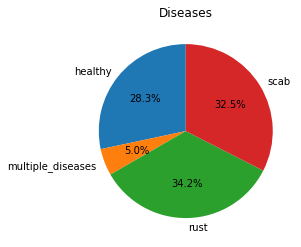

In [5]:
columns = ['healthy','multiple_diseases','rust','scab']
count = []

for i in columns:
    count.append(train_data[i].sum())

# Plot a pie chart
plt.pie(count, labels=columns, autopct='%1.1f%%', startangle=90)
plt.title("Diseases")
plt.show()

### Read and Pre-Process images

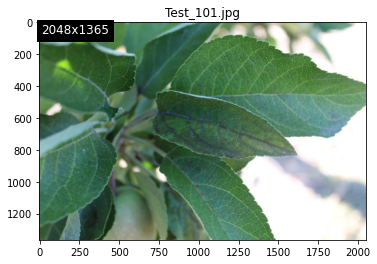

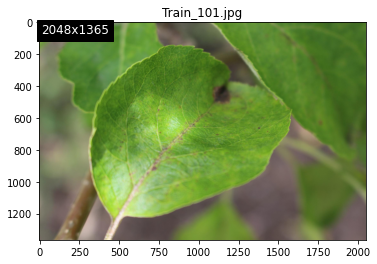

In [6]:
index = 101

test_img = f"{image_dir}/Test_{index}.jpg"
train_img = f"{image_dir}/Train_{index}.jpg"

# Iterate through the list of images
for file in [test_img,train_img]:
    image = Image.open(file)
    plt.imshow(image)
    plt.text(x=10, y=70, s=f'{image.size[0]}x{image.size[1]}', fontsize=12, color='white', backgroundcolor='black')
    plt.title(os.path.basename(file))
    plt.show()

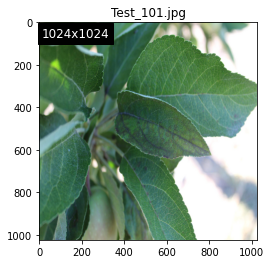

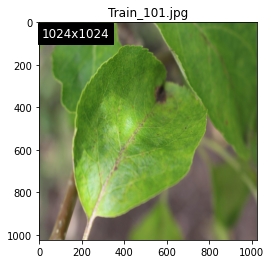

In [7]:
index = 101
new_size = (1024, 1024) #Resize images

test_img = f"{image_dir}/Test_{index}.jpg"
train_img = f"{image_dir}/Train_{index}.jpg"

# Iterate through the list of images
for file in [test_img,train_img]:
    image = Image.open(file).resize(new_size) #Resize
    plt.imshow(image)
    plt.text(x=10, y=70, s=f'{image.size[0]}x{image.size[1]}', fontsize=12, color='white', backgroundcolor='black')
    plt.title(os.path.basename(file))
    plt.show()

In [8]:
# def PreProcess(Dataset, size):
#     height, width = size

#     ids = Dataset['image_id']
#     Y = np.array(Dataset.drop(columns=['image_id']))

#     X = np.zeros((len(ids), height, width, 3))

#     for i, id_ in enumerate(ids):
#         img = tf.io.decode_image(tf.io.read_file(os.path.join(image_dir, "{}.jpg".format(id_))),channels=3)
#         img = tf.image.resize(img, size)
#         img = img / 255
#         X[i] = img
    
#     return ids, X, Y

In [9]:
def PreProcess(Dataset, size):
    height, width = size

    ids = Dataset['image_id']
    Y = np.array(Dataset.drop(columns=['image_id']))

    def image_process():
        for id_ in tqdm(ids):
            img = tf.io.decode_image(tf.io.read_file(os.path.join(image_dir, "{}.jpg".format(id_))), channels=3)
            img = tf.image.resize(img, size)
            img = img / 255
            yield img

    X = np.array(list(image_process()))

    return ids, X, Y

In [10]:
# def PreProcess(Dataset, size, image_dir):
#     ids = Dataset['image_id']
#     Y = np.array(Dataset.drop(columns=['image_id']))

#     # Create a dataset
#     dataset = tf.data.Dataset.from_tensor_slices(ids)
#     dataset = dataset.map(lambda x:tf.image.decode_jpeg(tf.io.read_file(os.path.join(image_dir, "{}.jpg".format(x))), channels=3))
#     dataset = dataset.map(lambda x:tf.image.resize(x, size))
#     dataset = dataset.map(lambda x:x/255)
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
#     return dataset, Y

In [11]:
image_size = [50,50]

#Pre-Process train images
with tf.device('/gpu:0'):
    ids,X,Y = PreProcess(train_data,image_size) 

2023-01-14 06:31:12.339311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 06:31:12.433818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 06:31:12.434690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 06:31:12.439232: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
print(f"X shape = {X.shape}")
print(f"Y shape = {Y.shape}")

X shape = (1821, 50, 50, 3)
Y shape = (1821, 4)


### Validation Split

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"X train shape = {X_train.shape}")
print(f"X validation shape = {X_val.shape}")
print(f"y train shape = {y_train.shape}")
print(f"y validation shape = {y_val.shape}")

X train shape = (1456, 50, 50, 3)
X validation shape = (365, 50, 50, 3)
y train shape = (1456, 4)
y validation shape = (365, 4)


### Model

In [14]:
# A plain model which uses dense layers

def plainNet(image_size):
    
    height,width = image_size
    input_shape = (height,width,3)
    
    inputs = Input(input_shape)
    
    X = Flatten()(inputs)
    X = Dense(128,activation='relu')(X)
    X = Dense(128,activation='relu')(X)
    X = Dense(4,activation='softmax')(X)
    
    # Create model
    model = Model(inputs = inputs, outputs = X)
    
    return model

In [15]:
model = plainNet(image_size)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 7500)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               960128    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 977,156
Trainable params: 977,156
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
with tf.device('/gpu:0'):
    model.fit(X_train, y_train, epochs = 100)

2023-01-14 06:31:59.381266: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
46/46 [==============================] - 2s 3ms/step - loss: 1.6388 - accuracy: 0.3359
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 1.2522 - accuracy: 0.3702
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 1.2191 - accuracy: 0.3674
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 1.2126 - accuracy: 0.4121
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 1.2068 - accuracy: 0.4066
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 1.1816 - accuracy: 0.4457
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 1.1711 - accuracy: 0.4526
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: 1.1628 - accuracy: 0.4595
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 1.1111 - accuracy: 0.5034
Epoch 10/100
46/46 [==============================] - 0s 4ms/step - loss: 1.1053 - accuracy: 0.4931
Epoch 11/